<a href="https://colab.research.google.com/github/ahmadryan/MLTSAProject/blob/master/RNN_network_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from collections import deque
import random
from numpy import *
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization#, CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
from sklearn import preprocessing
import pylab as pl
import os.path
from os import path
import matplotlib.pyplot as plt


In [0]:
#from tensorflow.keras.layers import CuDNNLSTM

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pwd

/content


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [6]:
cd Studies/Spring_2020/PHYS_667/Midterm/

/content/gdrive/My Drive/Studies/Spring_2020/PHYS_667/Midterm


In [0]:
#if(path.exists("guru99.txt"))
df_weather = pd.read_csv('https://github.com/takao8/MLTSAProject/raw/master/data/boston_weather_cleaned.csv', index_col='DATE')
df_weather.index = pd.to_datetime(df_weather.index)

In [0]:
df_weather.head()

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyWetBulbTemperature,HourlyWindSpeed
DATE,,,,,,,,
2000-01-01 00:00:00,30.18,18.0,28.0,0.0,66.0,30.17,NaN,8.0
2000-01-01 01:00:00,30.18,18.0,27.0,0.0,69.0,30.18,NaN,6.0
2000-01-01 01:00:00,30.18,17.0,27.0,0.0,66.0,30.18,24.0,6.0
2000-01-01 02:00:00,30.19,18.0,32.0,0.0,56.0,30.19,NaN,10.0
2000-01-01 03:00:00,30.22,19.0,30.0,0.0,64.0,30.21,NaN,8.0


In [0]:
df_weather.loc[df_weather.index.year>2010].isna().sum()
df_weather = df_weather.drop(["HourlyAltimeterSetting", "HourlySeaLevelPressure"], axis=1)

In [0]:
df_load = pd.read_excel('data/PJM_NEPOOL_hourly_data_Jan2000_Jul2019.xlsx')  #stat
df_load = df_load[['Date', 'KBOS_WCL_HIST', 'KBOS_HID_HIST', 'Nepool_Load_Hist']]

In [0]:
df_load.head()

,Date,KBOS_WCL_HIST,KBOS_HID_HIST,Nepool_Load_Hist
0,2000-01-01 13:59:59.712,43,47,12849.0
1,2000-01-01 15:00:00.000,40,45,12513.0
2,2000-01-01 16:00:00.288,39,43,12531.0
3,2000-01-01 16:59:59.712,37,41,13706.0
4,2000-01-01 18:00:00.000,37,40,15016.0


In [0]:
# rounding everything to the nearest hour, since some values are a little off
df_load['Date'] = pd.to_datetime(df_load['Date']).dt.round('H')

In [0]:
df_load.shape

(171562, 4)

In [0]:
# Creating dummy variables for month
a = [df_load['Date'][i].month for i in range(0, len(df_load))]
a = pd.get_dummies(a)
months = a.columns.values
for i in range(0, 12):
    df_load['Month%s' % (i+1)] = a.iloc[:, i]

# Creating dummy variables for hour
a = [df_load['Date'][i].hour for i in range(0, len(df_load))]
a = pd.get_dummies(a)
hours = a.columns.values
for i in range(0, 24):
    df_load['Hour%s' % (i+1)] = a.iloc[:, i]

In [0]:
df_load.set_index("Date", inplace=True)

In [0]:
df_load.shape, df_weather.shape

((171562, 39), (299592, 6))

In [0]:
df_merged = pd.merge(df_weather, df_load, left_index=True, right_index=True)
df_merged.dropna(inplace=True)

In [6]:
df_merged.to_pickle('data/merged_data.p')

NameError: ignored

In [0]:
df_scaled = pd.DataFrame()

col_list = ['HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
            'HourlyPrecipitation', 'HourlyRelativeHumidity',
            'HourlyWetBulbTemperature', 'HourlyWindSpeed', 'KBOS_WCL_HIST',
            'KBOS_HID_HIST', 'Nepool_Load_Hist']
col_list2 = ['Month1', 'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 
             'Month7', 'Month8', 'Month9', 'Month10', 'Month11', 'Month12', 
             'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5', 'Hour6', 'Hour7', 
             'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12', 'Hour13', 'Hour14',
             'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19', 'Hour20', 
             'Hour21', 'Hour22', 'Hour23', 'Hour24']
scaled_data = preprocessing.minmax_scale(df_merged[col_list], axis=0)

for i,col in enumerate(col_list) :
    df_scaled[col] = scaled_data[:,i]
for i,col in enumerate(col_list2) :
    df_scaled[col] = df_merged[col].values
df_scaled.set_index(df_merged.index, inplace=True)
df_scaled.dropna(inplace=True)

In [0]:
df_scaled.to_pickle('data/scaled_data.p')

##Read merged data

In [7]:
merged_data_file = '/content/gdrive/My Drive/Studies/Spring_2020/PHYS_667/Midterm/data/merged_data.p'
if(path.exists(merged_data_file)) :
   df_merged = pd.read_pickle(merged_data_file)
else:
    print('The file doesnt\'t exists')
df_merged.head()

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindSpeed,KBOS_WCL_HIST,KBOS_HID_HIST,Nepool_Load_Hist,Month1,Month2,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,Hour10,Hour11,Hour12,Hour13,Hour14,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23,Hour24
2000-01-01 16:00:00,31.0,46.0,0.0,56.0,40.0,18.0,39,43,12531.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2000-01-01 19:00:00,30.0,42.0,0.0,62.0,37.0,14.0,35,39,14951.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2000-01-02 01:00:00,35.0,36.0,0.0,97.0,36.0,7.0,30,36,10637.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-02 04:00:00,34.0,35.0,0.0,96.0,35.0,7.0,29,35,9731.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-02 07:00:00,34.0,35.0,0.0,96.0,35.0,6.0,30,35,10476.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
scaled_data_file = '/content/gdrive/My Drive/Studies/Spring_2020/PHYS_667/Midterm/data/scaled_data.p'
if(path.exists(scaled_data_file)) :
   df_scaled = pd.read_pickle(scaled_data_file)
else:
    print('The file doesnt\'t exists')
df_scaled.head()

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindSpeed,KBOS_WCL_HIST,KBOS_HID_HIST,Nepool_Load_Hist,Month1,Month2,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,Hour10,Hour11,Hour12,Hour13,Hour14,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23,Hour24
2000-01-01 16:00:00,0.533981,0.490909,0.0,0.516484,0.549451,0.008046,0.543478,0.458333,0.238981,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2000-01-01 19:00:00,0.524272,0.454545,0.0,0.582418,0.516484,0.006258,0.514493,0.425000,0.361019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2000-01-02 01:00:00,0.572816,0.400000,0.0,0.967033,0.505495,0.003129,0.478261,0.400000,0.143469,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-02 04:00:00,0.563107,0.390909,0.0,0.956044,0.494505,0.003129,0.471014,0.391667,0.097781,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-02 07:00:00,0.563107,0.390909,0.0,0.956044,0.494505,0.002682,0.478261,0.391667,0.135350,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df_scaled_short = df_scaled.iloc[::100]

In [10]:
df_scaled_short['Date'] = df_scaled_short.index.date
df_scaled_short['Hour'] = df_scaled_short.index.hour
df_scaled_short['DateTime'] = df_scaled_short.index

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [11]:
df_scaled_short.Nepool_Load_Hist.head()

2000-01-01 16:00:00    0.238981
2000-01-20 04:00:00    0.291578
2000-02-07 19:00:00    0.532930
2000-02-24 13:00:00    0.380888
2000-03-12 04:00:00    0.104085
Name: Nepool_Load_Hist, dtype: float64

In [12]:
psd = np.abs(f[:int((N+1)/2 + 0.5)])**2
x_val = np.fft.rfftfreq(N, 1.0/sample_rate)

NameError: ignored

In [0]:
def get_fft(df=None, key='Nepool_Load_Hist', sr=1):

    '''Function tpo create a dataframe which will have all the frequencies and
    PSD values given a dataframe and the key and samplerate'''
    sample_rate = sr
    df[key].dropna(inplace=True)
    N = len(df)
    f = np.fft.fft(array(df[key].values))

    psd = np.abs(f[:int((N+1)/2 + 0.5)])**2
    x_val = np.fft.rfftfreq(N, 1.0/sample_rate)

    df_fft = pd.DataFrame()
    df_fft['freq'] = x_val
    df_fft['psd'] = psd

    return df_fft

In [0]:
df_resampled = df_merged.resample('1H').mean()
df_resampled.to_pickle('data/resampled_data.p')

In [0]:
df_resampledn = pd.read_pickle('data/resampled_data.p')

In [16]:
df_resampledn.head()

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindSpeed,KBOS_WCL_HIST,KBOS_HID_HIST,Nepool_Load_Hist,Month1,Month2,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,Hour10,Hour11,Hour12,Hour13,Hour14,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23,Hour24
2000-01-01 16:00:00,31.0,46.0,0.0,56.0,40.0,18.0,39.0,43.0,12531.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 19:00:00,30.0,42.0,0.0,62.0,37.0,14.0,35.0,39.0,14951.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2000-01-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df_spring = df_resampledn.iloc[(df_resampledn.index.month >=3) & (df_resampledn.index.month <= 5)]
df_summer = df_resampledn.iloc[(df_resampledn.index.month >=6) & (df_resampledn.index.month <= 8)]
df_autumn = df_resampledn.iloc[(df_resampledn.index.month >=9) & (df_resampledn.index.month <= 11)]
df_winter = df_resampledn.iloc[(df_resampledn.index.month <=2) | (df_resampledn.index.month >=12)]

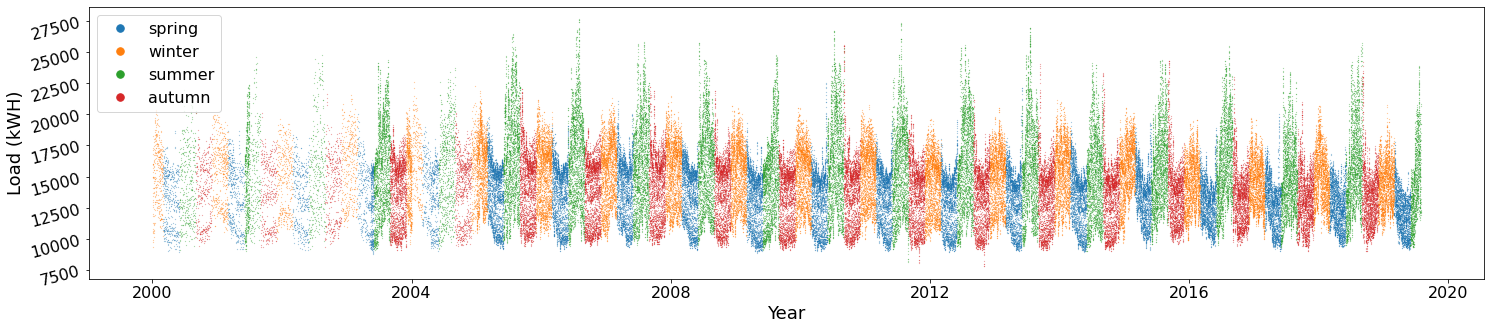

In [147]:
plt.figure(figsize=(25,5))
plt.plot(df_spring.Nepool_Load_Hist, '.', ms=0.3, label='spring')
plt.plot(df_winter.Nepool_Load_Hist, '.', ms=0.3, label='winter')
plt.plot(df_summer.Nepool_Load_Hist, '.', ms=0.3, label='summer')
plt.plot(df_autumn.Nepool_Load_Hist, '.', ms=0.3, label='autumn')

lgnd1 = plt.legend(fontsize=16);
lgnd1.legendHandles[0]._legmarker.set_markersize(15)
lgnd1.legendHandles[1]._legmarker.set_markersize(15)
lgnd1.legendHandles[2]._legmarker.set_markersize(15)
lgnd1.legendHandles[3]._legmarker.set_markersize(15)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=15)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Load (kWH)', fontsize=18);

In [136]:
plt.axes.xticklabels?

Object `plt.axes.xticklabels` not found.


In [55]:
df_autumn.Nepool_Load_Hist.describe(), df_spring.Nepool_Load_Hist.describe(), df_summer.Nepool_Load_Hist.describe(), df_autumn.Nepool_Load_Hist.describe()

(count    34412.000000
 mean     13734.733618
 std       2439.353442
 min       7792.000000
 25%      11642.867500
 50%      13935.000000
 75%      15464.000000
 max      25572.000000
 Name: Nepool_Load_Hist, dtype: float64, count    35552.000000
 mean     13314.516419
 std       2138.402410
 min       8820.000000
 25%      11574.000000
 50%      13460.675000
 75%      14958.495000
 max      22491.000000
 Name: Nepool_Load_Hist, dtype: float64, count    36686.000000
 mean     15826.707862
 std       3443.201533
 min       8182.000000
 25%      13153.000000
 50%      15623.000000
 75%      18200.887500
 max      27622.000000
 Name: Nepool_Load_Hist, dtype: float64, count    34412.000000
 mean     13734.733618
 std       2439.353442
 min       7792.000000
 25%      11642.867500
 50%      13935.000000
 75%      15464.000000
 max      25572.000000
 Name: Nepool_Load_Hist, dtype: float64)

In [0]:
df_autumn.to_pickle('autumn.p')
df_spring.to_pickle('spring.p')
df_summer.to_pickle('summer.p')
df_winter.to_pickle('winter.p')

In [0]:
df_autumnn = pd.read_pickle('autumn.p')
df_springn = pd.read_pickle('spring.p')
df_summern = pd.read_pickle('summer.p')
df_wintern = pd.read_pickle('winter.p')

In [70]:
'Nepool_Load_Hist' in df_wintern.keys()

True

Text(0.05, 0.95, 'autumn')

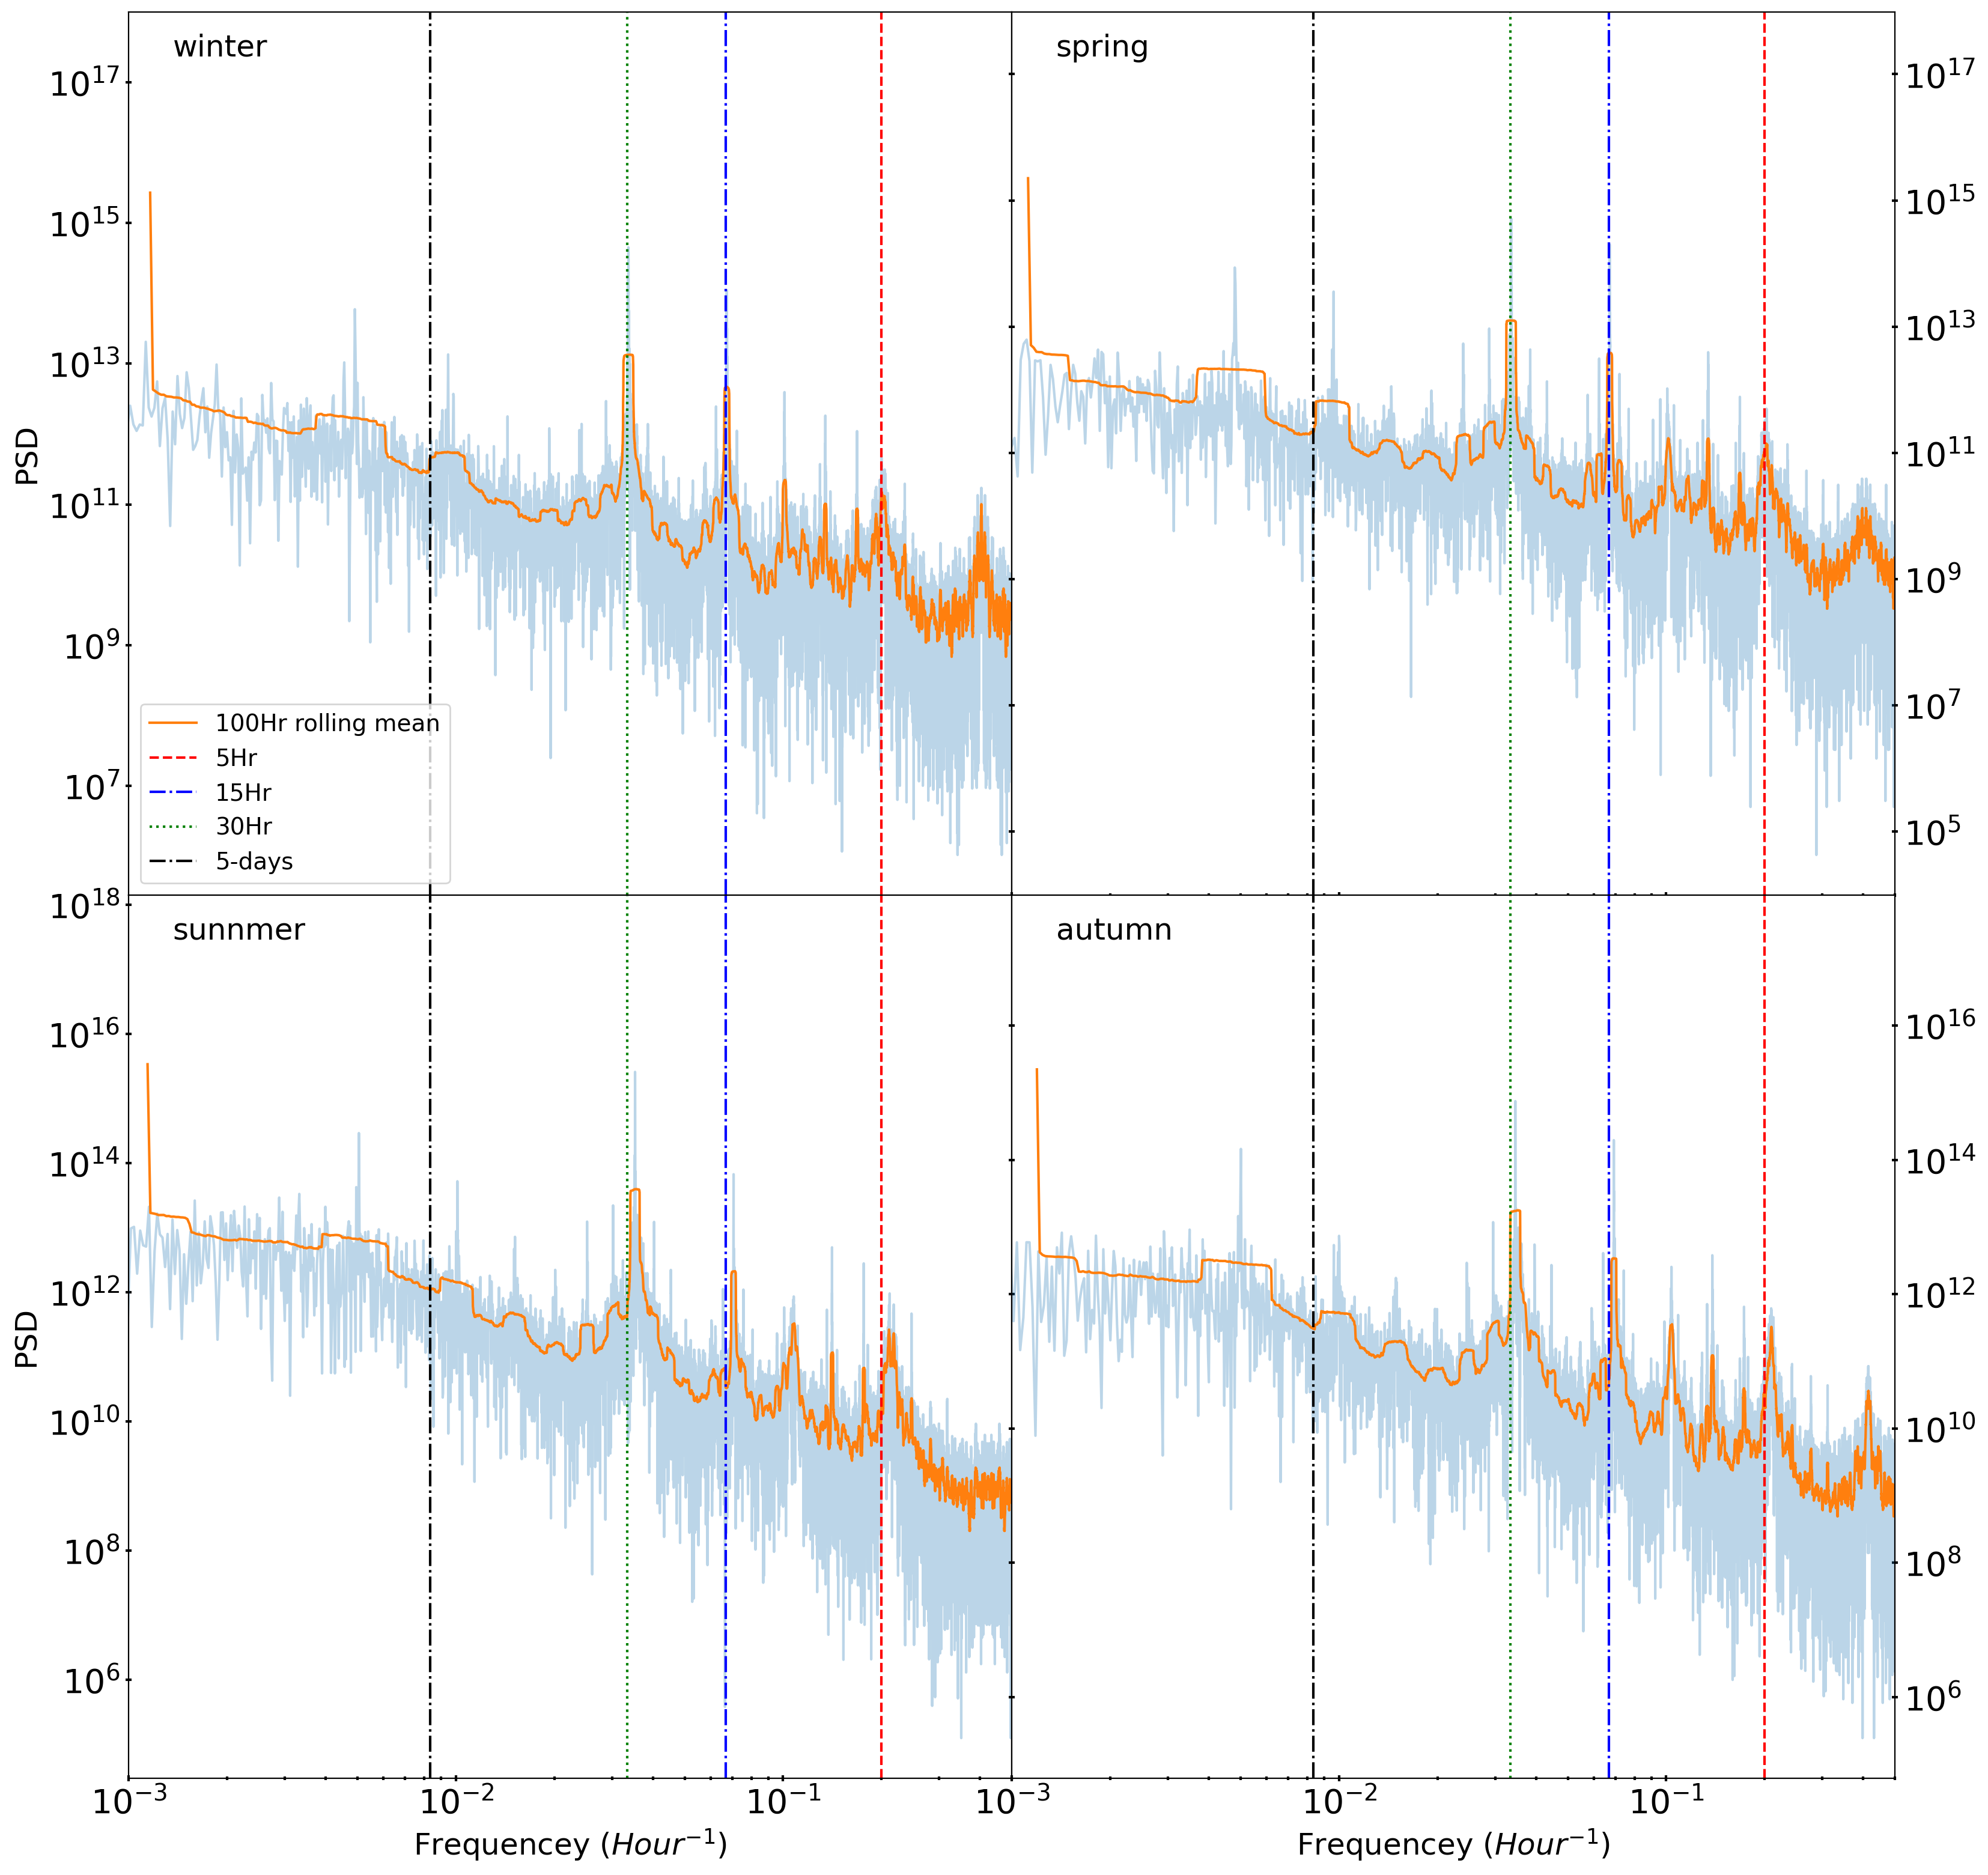

In [126]:
#Fourier transform
sample_rate = 1 #samples per hour
win_len = 100

fig = plt.figure( num=None, figsize=( 15, 15 ), dpi=200, facecolor='w', 
                 edgecolor='gray' )
fig.subplots_adjust( left=0.01, right=0.99, top=0.99, bottom=0.01, 
wspace=0.0, hspace=0. )

# Define the axes in the figure

axs1 = fig.add_subplot( 2, 2, 1 )

df_fft = get_fft(df_winter)

axs1.plot( df_fft.freq, df_fft.psd, alpha=0.3)
axs1.plot( df_fft.freq.rolling(win_len).mean(), df_fft.psd.rolling(win_len).mean(), label='100Hr rolling mean')
axs1.axvline(1/5., label='5Hr', color='r', ls='--')
axs1.axvline(1/15., label='15Hr', color='b', ls='-.')
axs1.axvline(1/30., label='30Hr', color='g', ls='dotted')
axs1.axvline(1/(24*5.), label='5-days', color='k', ls='dashdot')
axs1.axes.tick_params( which='both', direction='inout',labelbottom=False, 
                    bottom=False, width=1.5, labelsize=20, labelrotation=0 )
axs1.set_yscale('log')
axs1.set_xscale('log')
axs1.set_xlim(1.e-3, 0.5)
axs1.legend(fontsize=14)
#axs1.set_xlabel(r'Frequencey (${Hour}^{-1}$)', fontsize=18)
axs1.set_ylabel('PSD', fontsize=18)

axs2 = fig.add_subplot( 2, 2, 2 )

df_fft = get_fft(df_spring)

axs2.plot( df_fft.freq, df_fft.psd, alpha=0.3)
axs2.plot( df_fft.freq.rolling(win_len).mean(), df_fft.psd.rolling(win_len).mean(), label='100Hr rolling mean')
axs2.axvline(1/5., label='5Hr', color='r', ls='--')
axs2.axvline(1/15., label='15Hr', color='b', ls='-.')
axs2.axvline(1/30., label='30Hr', color='g', ls='dotted')
axs2.axvline(1/(24*5.), label='5-days', color='k', ls='dashdot')
axs2.axes.tick_params( which='both', direction='inout',labelbottom=False, 
                    bottom=True, left=True, labelleft=False, right=True, 
                    labelright=True, width=1.5, labelsize=20, labelrotation=0 )
axs2.set_yscale('log')
axs2.set_xscale('log')
axs2.set_xlim(1.e-3, 0.5)
#axs2.legend(fontsize=14)
#axs2.set_xlabel(r'Frequencey (${Hour}^{-1}$)', fontsize=18)
#axs2.set_ylabel('PSD', fontsize=18)

axs3 = fig.add_subplot( 2, 2, 3 )

df_fft = get_fft(df_summer)

axs3.plot( df_fft.freq, df_fft.psd, alpha=0.3)
axs3.plot( df_fft.freq.rolling(win_len).mean(), df_fft.psd.rolling(win_len).mean(), label='100Hr rolling mean')
axs3.axvline(1/5., label='5Hr', color='r', ls='--')
axs3.axvline(1/15., label='15Hr', color='b', ls='-.')
axs3.axvline(1/30., label='30Hr', color='g', ls='dotted')
axs3.axvline(1/(24*5.), label='5-days', color='k', ls='dashdot')
axs3.axes.tick_params( which='both', direction='inout',labelbottom=True, 
                    bottom=True, width=1.5, labelsize=20, labelrotation=0 )
axs3.set_yscale('log')
axs3.set_xscale('log')
axs3.set_xlim(1.e-3, 0.5)
#axs3.legend(fontsize=14)
axs3.set_xlabel(r'Frequencey (${Hour}^{-1}$)', fontsize=18)
axs3.set_ylabel('PSD', fontsize=18)

axs4 = fig.add_subplot( 2, 2, 4 )

df_fft = get_fft(df_autumn)

axs4.plot( df_fft.freq, df_fft.psd, alpha=0.3)
axs4.plot( df_fft.freq.rolling(win_len).mean(), df_fft.psd.rolling(win_len).mean(), label='100Hr rolling mean')
axs4.axvline(1/5., label='5Hr', color='r', ls='--')
axs4.axvline(1/15., label='15Hr', color='b', ls='-.')
axs4.axvline(1/30., label='30Hr', color='g', ls='dotted')
axs4.axvline(1/(24*5.), label='5-days', color='k', ls='dashdot')
axs4.axes.tick_params( which='both', direction='inout',labelbottom=True, 
                    bottom=True, left=True, labelleft=False, right=True, 
                    labelright=True, width=1.5, labelsize=20, labelrotation=0 )
axs4.set_yscale('log')
axs4.set_xscale('log')
axs4.set_xlim(1.e-3, 0.5)
#axs4.legend(fontsize=14)
axs4.set_xlabel(r'Frequencey (${Hour}^{-1}$)', fontsize=18)
#axs4.set_ylabel('PSD', fontsize=18)
axs1.text( 0.05, 0.95, 'winter',  fontsize=18, transform=axs1.transAxes )
axs2.text( 0.05, 0.95, 'spring',  fontsize=18, transform=axs2.transAxes )
axs3.text( 0.05, 0.95, 'sunnmer', fontsize=18, transform=axs3.transAxes )
axs4.text( 0.05, 0.95, 'autumn',  fontsize=18, transform=axs4.transAxes )

#plt.suptitle('Speactral density for different seasons', fontsize=16)

# Feature extractions

In [0]:
df_resampledn = pd.read_pickle('data/resampled_data.p')

In [0]:
means = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])[['Nepool_Load_Hist']].mean()
stds = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])[['Nepool_Load_Hist']].std()

In [0]:
features = []
features = means.rename({"Nepool_Load_Hist": "means"}, 
                        axis=1).merge(stds.rename({"Nepool_Load_Hist": "stds"}, 
                                axis=1), left_index=True, right_index=True)

In [0]:
maxs = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])[['Nepool_Load_Hist']].max()
mins = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])[['Nepool_Load_Hist']].min()

features['maxs'] = maxs
features['mins'] = mins

In [0]:
def normalized_max(x) :
    return nanmax(( x -  nanmean(x) ) /nanstd(x))

def normalized_min(x) :
    return nanmin(( x -  nanmean(x) ) /nanstd(x))

def normalized_mean(x) :
    return nanmean( x -  nanmean(x))

def normalized_std(x) :
    return nanstd( ( x -  nanmean(x) )/nanstd(x))

In [0]:
normed_mean = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])['Nepool_Load_Hist'].apply(normalized_mean)
normed_std = df_resampledn.groupby( [df_resampledn.index.month, df_resampledn.index.day])['Nepool_Load_Hist'].apply(normalized_std)

features['normed_mean'] = normed_mean
features['normed_std'] = normed_std

In [0]:
normed_max = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])['Nepool_Load_Hist'].apply(normalized_max)
normed_min = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])['Nepool_Load_Hist'].apply(normalized_min)

features['normed_max'] = normed_max
features['normed_min'] = normed_min

In [0]:
from scipy import stats 
def moment_computation(x, moment_order):
    '''Define a function to compute moment of a distribution given the 
    distribution and order of moment
    '''
    x.dropna(inplace=True)
    return stats.moment(x, moment = moment_order)

In [0]:
variance = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])['Nepool_Load_Hist'].apply( moment_computation, moment_order=2)
skewness = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])['Nepool_Load_Hist'].apply( moment_computation, moment_order=3)
kurtosis = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])['Nepool_Load_Hist'].apply( moment_computation, moment_order=4)

features['variance'] = variance
features['skewness'] = skewness
features['kurtosis'] = kurtosis

In [294]:

%%time
def linfit(x):
    x.dropna(inplace=True)
    pars = np.polyfit(range(len(x)), x.values, 1)
    return pars
linfits = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])['Nepool_Load_Hist'].apply(linfit)
slopes = [x[0] for x in linfits.values[:]]
intercepts = [x[1] for x in linfits.values[:]]
features["slopes"] = slopes
features["intercepts"] = intercepts

CPU times: user 297 ms, sys: 899 µs, total: 298 ms
Wall time: 301 ms


In [0]:
def quadfit(x):
    x.dropna(inplace=True)
    pars = np.polyfit(range(len(x)), x.values, 2)
    return pars
quadfits = df_resampledn.groupby([df_resampledn.index.month, df_resampledn.index.day])['Nepool_Load_Hist'].apply(quadfit)
ll1 = [x[0] for x in quadfits.values[:]]
ll2 = [x[1] for x in quadfits.values[:]]
ll3 = [x[2] for x in quadfits.values[:]]

features["ll1"] = ll1
features["ll2"] = ll2
features["ll3"] = ll3

In [312]:
features

means         stds      maxs  ...       ll1        ll2           ll3
1  1   14085.501180  2049.033455  20314.02  ... -0.005536   3.727815  13647.838547
   2   14978.939321  2590.710856  20794.00  ... -0.002702   3.902216  14365.208975
   3   15570.595587  2465.615349  21445.00  ... -0.028786  11.103802  14851.797625
   4   15600.608189  2252.240430  19760.00  ... -0.034947  12.880678  14837.586686
   5   15444.971421  2285.050211  20663.15  ... -0.015480   6.857038  14887.712304
...             ...          ...       ...  ...       ...        ...           ...
12 27  14596.296553  2335.075840  20641.00  ...  0.007941  -3.642324  14905.791514
   28  14748.191974  2327.043435  20522.84  ...  0.016399  -5.346055  14975.037139
   29  14939.389263  2372.471021  20476.00  ... -0.014040   5.992191  14476.983262
   30  14939.381211  2175.296028  19440.00  ... -0.017377   7.822960  14290.029170
   31  14694.251489  2052.618197  19860.27  ... -0.019233   9.567292  13805.148763

[366 rows x 16 columns]

#Clustering studies

In [313]:
%%time
X = features.iloc[:,:-1]
y = features.iloc[:,-1]

import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split( X, y, test_size=0.25, random_state=345, shuffle=True)
#remember to use the random state so that your work is reproducible and use a split between 60-40 and 75-25.

CPU times: user 5.24 ms, sys: 3 µs, total: 5.24 ms
Wall time: 7.17 ms


In [314]:
%%time
from sklearn import preprocessing
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)

print("scaled training data feature mean and standard deviations: ", 
      Xtrain_scaled.mean(axis=0), Xtrain_scaled.std(axis=0))

scaled training data feature mean and standard deviations:  [-2.59322166e-17 -5.18644333e-17  1.29661083e-17 -2.59322166e-17
  0.00000000e+00  1.62076354e-17  1.29661083e-17  3.24152708e-17
  3.88983250e-17  1.29661083e-17  1.29661083e-17 -2.59322166e-17
  6.48305416e-18  0.00000000e+00  9.72458124e-18] [1.         1.         1.         1.         1.         0.87800548
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
CPU times: user 4.64 ms, sys: 44 µs, total: 4.69 ms
Wall time: 9.07 ms


In [0]:
from sklearn.manifold import TSNE

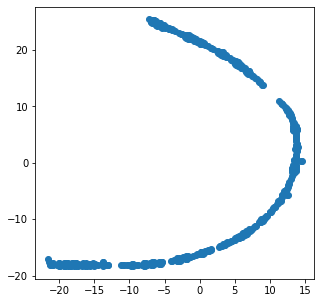

CPU times: user 3.19 s, sys: 70 ms, total: 3.26 s
Wall time: 1.71 s


In [316]:
%%time
X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.show()

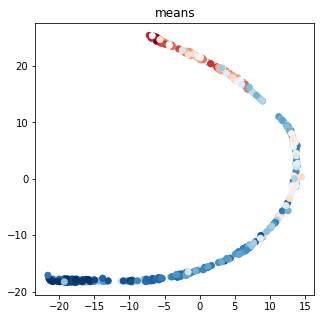

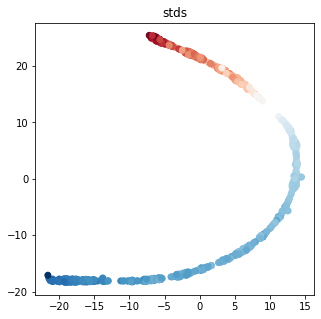

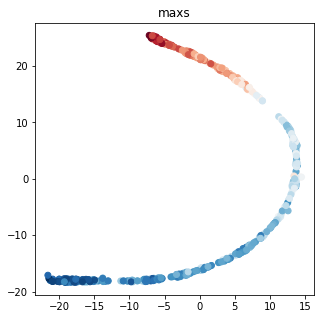

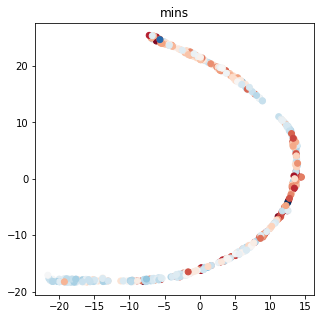

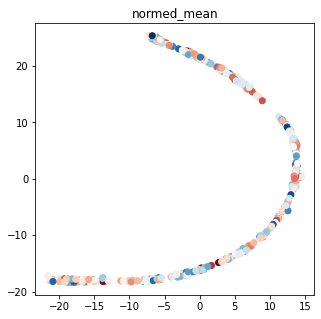

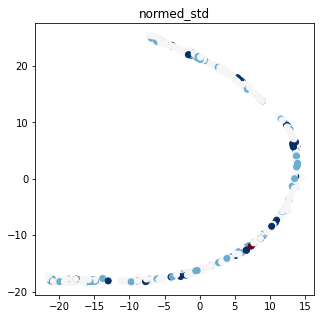

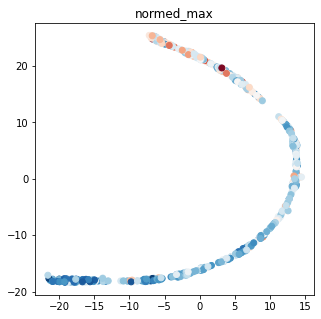

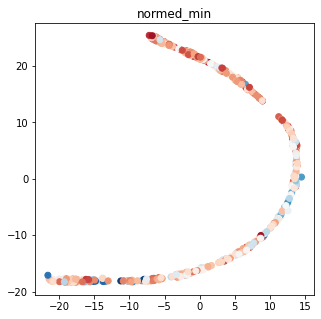

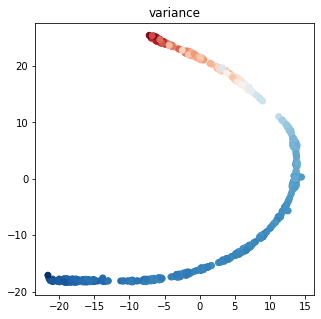

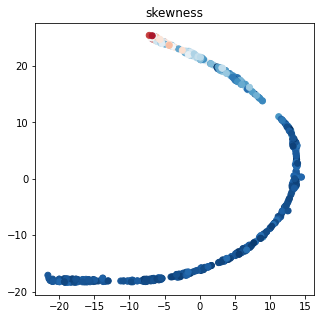

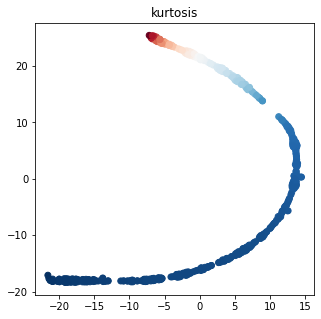

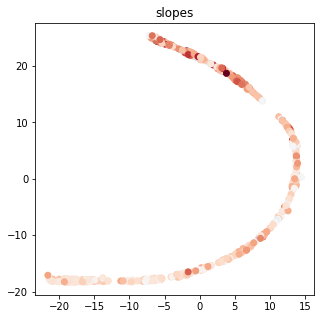

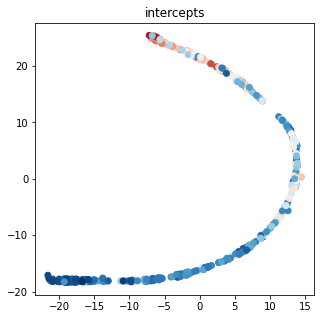

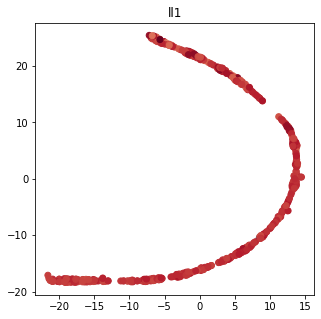

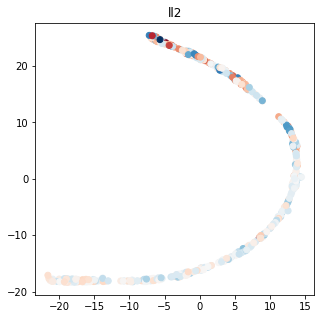

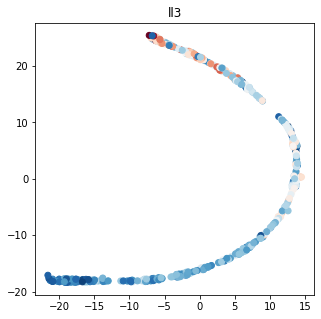

CPU times: user 4.62 s, sys: 1.81 s, total: 6.43 s
Wall time: 4.27 s


In [326]:
%%time
for col in features.columns:
    v = features[col].astype(float)
    pl.figure(figsize=(5,5))
    pl.title(col)
    pl.scatter(X_embedded[:,0], X_embedded[:,1],  color=[pl.cm.RdBu_r(pl.Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])

    pl.show()

In [327]:
X_scaled = preprocessing.scale(X)
print("scaled training data feature mean and standard deviations: ", 
      X_scaled.mean(axis=0), X_scaled.std(axis=0))

scaled training data feature mean and standard deviations:  [ 3.88274719e-17  0.00000000e+00 -5.82412078e-17 -6.79480758e-17
  1.21335850e-17  5.82412078e-17  4.36809059e-17  0.00000000e+00
  3.88274719e-17 -1.94137359e-17 -7.76549438e-17  0.00000000e+00
  3.88274719e-17 -9.70686797e-18 -1.94137359e-17] [1.         1.         1.         1.         1.         0.87512186
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]


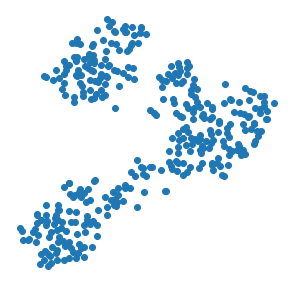

CPU times: user 3.45 s, sys: 34.2 ms, total: 3.49 s
Wall time: 1.79 s


In [328]:
%%time

X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X_scaled)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.axis('off')
pl.show()

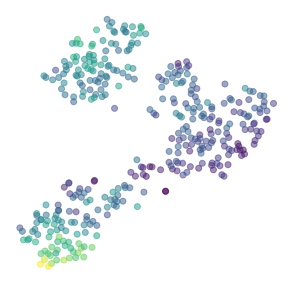

In [329]:
norm_obj= pl.Normalize(vmin=y.min(), vmax=y.max())
len([c for c in pl.cm.RdBu_r(norm_obj(y))]), X_embedded.shape
pl.figure(figsize=(5,5))
pl.axis('off')
pl.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y))], alpha=0.5);

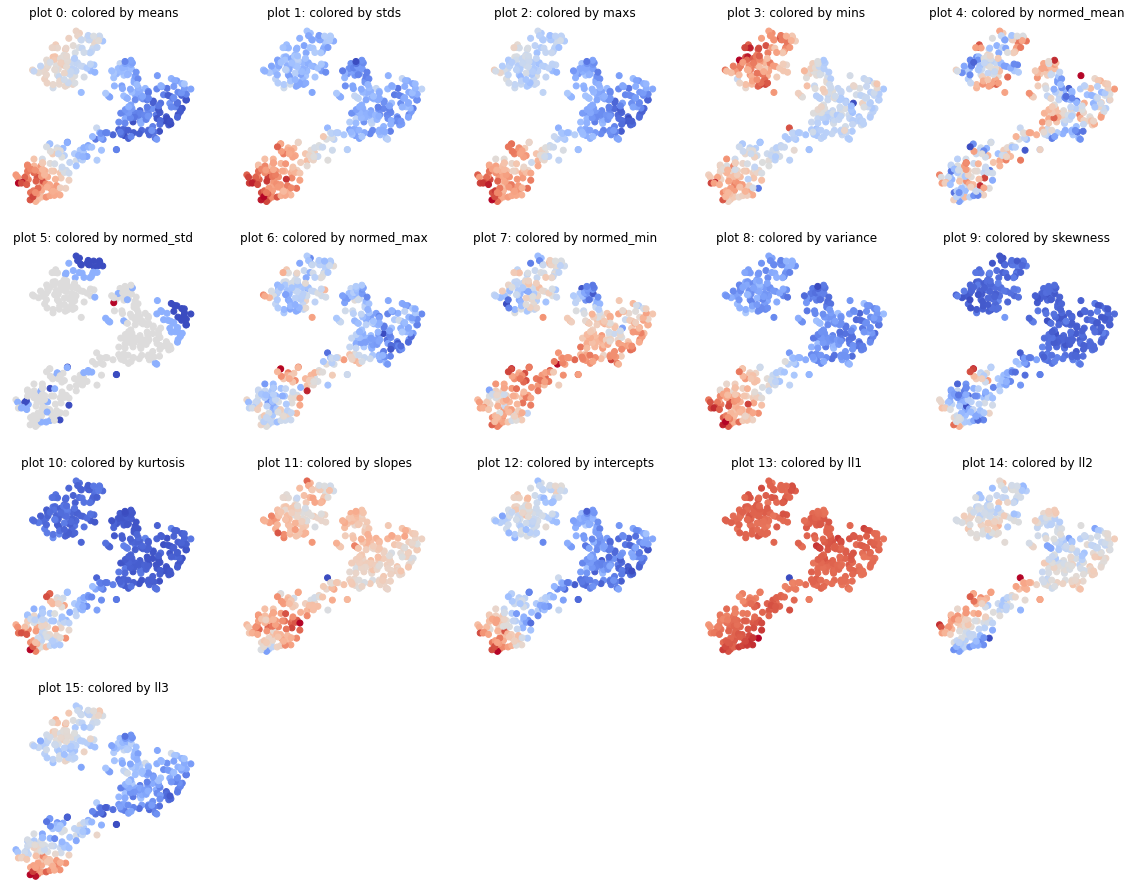

In [331]:
fig = pl.figure(figsize=(20,20))
# note: I am avoiding the first column of metadata which is the object identifier
for i, col in enumerate(features.columns[:]):
    ax = fig.add_subplot(5,5,i+1)
    v = features[col].astype(float)
    ax.set_title("plot %d: colored by %s"%(i,col))
    ax.scatter(X_embedded[:,0], X_embedded[:,1],  
               color=[pl.cm.coolwarm(pl.Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])
    ax.axis('off')

    #pl.show()

In [0]:
from sklearn.cluster import AgglomerativeClustering

elements in cluster 0 183
elements in cluster 1 81
elements in cluster 2 102



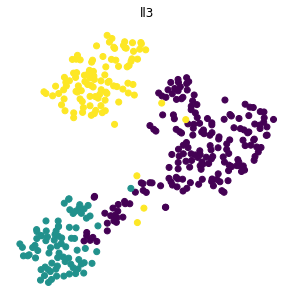

In [334]:
clustering = AgglomerativeClustering(n_clusters=3).fit(X_scaled)

for j in range(3):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
print()
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(pl.Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()

elements in cluster 0 285
elements in cluster 1 81



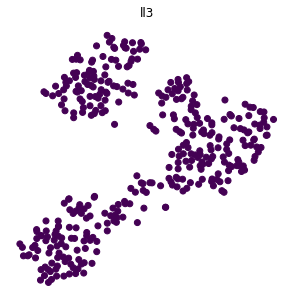

elements in cluster 0 183
elements in cluster 1 81
elements in cluster 2 102



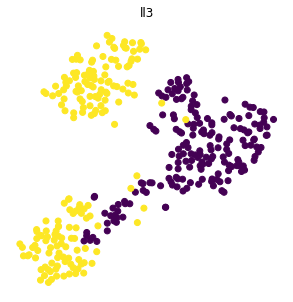

elements in cluster 0 102
elements in cluster 1 81
elements in cluster 2 149
elements in cluster 3 34



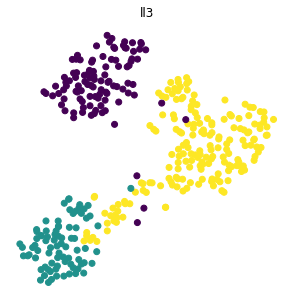

elements in cluster 0 81
elements in cluster 1 101
elements in cluster 2 149
elements in cluster 3 34
elements in cluster 4 1



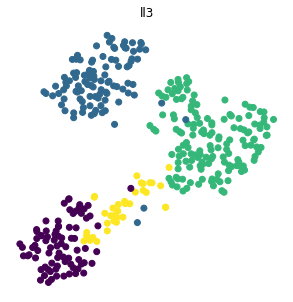

In [336]:
for n in range(2,6):
    clustering = AgglomerativeClustering(n_clusters=n).fit(X_scaled)

    for j in range(n):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
    print()
    pl.figure(figsize=(5,5))
    pl.title(col)

    #using a color map normalized according to the number of clusters:
    # for 3 clusters vmin=0, vmax=2
    colors = np.array([pl.cm.viridis(pl.Normalize(vmin=0, vmax=j-1)(c))
                                                         for c in clustering.labels_])
    # changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
    alpha = np.array([1 if (clustering.labels_ == j).sum() > 2 else 1.0 for j in clustering.labels_])
    # setting the alpha channel by replacing the default of the colormap which is 1
    colors[:,3] = alpha
    
    pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
                color=colors);
    pl.axis('off')
    pl.show()

##Changing the distance measuring method

In [0]:
from scipy.spatial.distance import cdist

In [0]:
clustering = AgglomerativeClustering(n_clusters=n).fit(X_scaled)

In [339]:
dist = cdist(X_scaled, X_scaled, metric='braycurtis')
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
                                    linkage="complete").fit(dist)
for j in range(2, -1, -1):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))

elements in cluster 2 99
elements in cluster 1 104
elements in cluster 0 163


elements in cluster 0 163
elements in cluster 1 104
elements in cluster 2 99



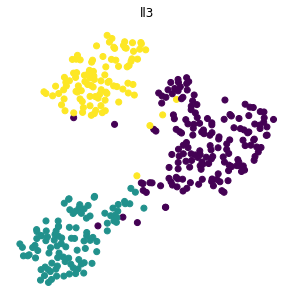

In [340]:
for j in range(3):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
print()
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(pl.Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()

In [0]:
df_merged = pd.read_pickle('data/merged_data.p')

In [0]:
df_scaled = pd.read_pickle('data/scaled_data.p')

#Neural Networks

In [0]:
def preprocess_df(df, ind1, ind2, tlen, key):
    '''The function prepocesses a dataframe and prep it for use in a RNN model 
    based on various parameters and returns x and y training/test or validation 
    set:
    df: input dataframe
    ind1: starting index
    ind2: end index
    key: key corresponding to the target variable
    '''
    df_n = df.iloc[ind1:ind2]
    y_set = df_n[key]
    x_set = df_n.drop(key, axis=1)

    return np.array(x_set), np.array(y_set)

In [0]:
df_scaled_short = df_scaled[:-10000]
msk = np.random.rand(len(df_scaled_short)) < 0.8

train = df_scaled_short[msk]
val = df_scaled_short[~msk]
test = df_scaled[-10000:]

In [0]:
df_train = train
x_trainn = full((1000, int(train.shape[0]/1000 ), 44), NaN)
y_trainn = full((1000, int(train.shape[0]/1000 ),1), NaN)

df_val = val
x_valn = full((int(val.shape[0]/1000), int(train.shape[0]/1000 ), 44), NaN)
y_valn = full((int(val.shape[0]/1000), int(train.shape[0]/1000 ),1), NaN)

for i in range(1000):

    ind1 = int(train.shape[0]/1000 )*i
    ind2 = int(train.shape[0]/1000 )*(i+1)
    x_trainn[i,:,:] = df_train.iloc[ind1:ind2].drop(['Nepool_Load_Hist'], axis=1).values
    y_trainn[i,:,0] = df_train.Nepool_Load_Hist[ind1:ind2].values

for j in range(int(val.shape[0]/1000 )):

    ind1 = int(train.shape[0]/1000 )*j
    ind2 = int(train.shape[0]/1000 )*(j+1)
    x_valn[j,:,:] = df_val.iloc[ind1:ind2].drop(['Nepool_Load_Hist'], axis=1).values
    y_valn[j,:,0] = df_val.Nepool_Load_Hist[ind1:ind2].values

In [0]:
df_test = test
x_testn = full((int(test.shape[0]), 1, 44), NaN)
y_testn = full((int(test.shape[0]), 1, 1), NaN)

for j in range(int(test.shape[0])-1):

    ind1 = j
    ind2 = j+1
    x_testn[j,0,:] = df_test.iloc[ind1:ind2].drop(['Nepool_Load_Hist'], axis=1).values
    y_testn[j,0,0] = df_test.Nepool_Load_Hist[ind1:ind2].values[0]

In [182]:
x_trainn.shape, x_valn.shape, x_testn.shape

((1000, 163, 44), (40, 163, 44), (10000, 1, 44))

In [0]:
#train_data = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=train.drop(['Nepool_Load_Hist'], axis=1), targets=train['Nepool_Load_Hist'], length=1000, shuffle=True)
#test_data = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=test.drop(['Nepool_Load_Hist'], axis=1), targets=test['Nepool_Load_Hist'], length=1000, shuffle=True)

In [0]:
#(train_data.batch_size+test_data.batch_size) * (len(test_data)+len(train_data) )

424192

In [0]:
#x_trainn = train_data.data.values
#y_trainn = train_data.targets.values
#
#x_valn = test_data.data.values
#y_valn = test_data.targets.values

In [0]:
train_data.batch_size

In [0]:
#df_scaled_clean = df_scaled.dropna()
#x_train, y_train = preprocess_df(df_scaled_clean, 0, 50000, 'Nepool_Load_Hist')
#x_val, y_val = preprocess_df(df_scaled_clean, 50010, 60000, 'Nepool_Load_Hist')
#x_test, y_test = preprocess_df(df_scaled_clean, 60010, 80000, 'Nepool_Load_Hist')

In [0]:
#Define the model

model = Sequential()
model.add(LSTM(128, input_shape=x_trainn.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, input_shape=x_trainn.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128, input_shape=x_trainn[1:].shape))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1)) # Make this number fo features

In [184]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 163, 128)          88576     
_________________________________________________________________
dropout_8 (Dropout)          (None, 163, 128)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 163, 128)          512       
_________________________________________________________________
lstm_7 (LSTM)                (None, 163, 128)          131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 163, 128)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 163, 128)          512       
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)              

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

In [0]:
#model.compile(
#    loss='sparse_categorical_crossentropy',
#    optimizer=opt,
#    metrics=['accuracy']
#)

In [0]:
# Compile model
model.compile(
    loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [0]:
seq_len = 50000
fut_pred = 10000

name = f"seq-{seq_len}-pred-{fut_pred}-{int(time.time())}"
tensorboard = TensorBoard(log_dir="logs/{}".format(name))

In [0]:
nepoch = 1200
nbatch = 24
filepath = "RNN_Final-{nepoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

In [190]:
%%time

# Train model
history = model.fit(
    x_trainn, y_trainn,
    batch_size=nbatch,
    epochs=nepoch, verbose=2, validation_data=(x_valn, y_valn)
    #callbacks=[tensorboard, checkpoint]
)

Epoch 1/1200
42/42 - 2s - loss: 0.4854 - accuracy: 1.2270e-05 - val_loss: 0.0319 - val_accuracy: 0.0000e+00
Epoch 2/1200
42/42 - 1s - loss: 0.3293 - accuracy: 1.8405e-05 - val_loss: 0.0285 - val_accuracy: 0.0000e+00
Epoch 3/1200
42/42 - 1s - loss: 0.2518 - accuracy: 1.8405e-05 - val_loss: 0.0440 - val_accuracy: 0.0000e+00
Epoch 4/1200
42/42 - 1s - loss: 0.2088 - accuracy: 1.2270e-05 - val_loss: 0.0605 - val_accuracy: 0.0000e+00
Epoch 5/1200
42/42 - 1s - loss: 0.1897 - accuracy: 0.0000e+00 - val_loss: 0.0312 - val_accuracy: 0.0000e+00
Epoch 6/1200
42/42 - 1s - loss: 0.1560 - accuracy: 1.2270e-05 - val_loss: 0.0275 - val_accuracy: 0.0000e+00
Epoch 7/1200
42/42 - 1s - loss: 0.1283 - accuracy: 1.2270e-05 - val_loss: 0.0239 - val_accuracy: 0.0000e+00
Epoch 8/1200
42/42 - 1s - loss: 0.1109 - accuracy: 1.2270e-05 - val_loss: 0.0269 - val_accuracy: 0.0000e+00
Epoch 9/1200
42/42 - 1s - loss: 0.0924 - accuracy: 1.2270e-05 - val_loss: 0.0276 - val_accuracy: 0.0000e+00
Epoch 10/1200
42/42 - 1s - l

In [0]:
filepath

'RNN_Final-{epoch:02d}-{accuracy:.3f}'

In [191]:
# Score model
score = model.evaluate(x_valn, y_valn, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model
model.save("models/{}".format(name))

2/2 [==============================] - 0s 8ms/step - loss: 0.0208 - accuracy: 0.0000e+00
Test loss: 0.02081850916147232
Test accuracy: 0.0
INFO:tensorflow:Assets written to: models/seq-50000-pred-10000-1589055084/assets


In [19]:
# Score model
score = model.evaluate(x_valn, y_valn, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model
model.save("models/{}".format(NAME))

2/2 [==============================] - 0s 11ms/step - loss: 0.0208 - accuracy: 0.0000e+00
Test loss: 0.02083704248070717
Test accuracy: 0.0


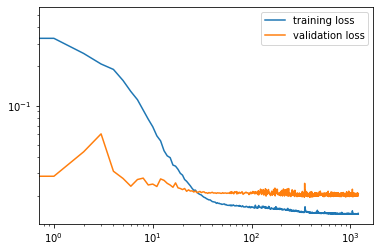

In [194]:
#PLot history
pl.plot(np.array(history.history['loss']), label='training loss')
pl.plot(np.array(history.history['val_loss']), label='validation loss')
pl.legend()
pl.yscale('log')
pl.xscale('log')

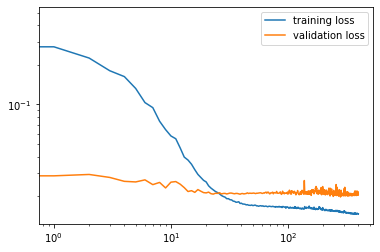

In [21]:
#PLot history
pl.plot(np.array(history.history['loss']), label='training loss')
pl.plot(np.array(history.history['val_loss']), label='validation loss')
pl.legend()
pl.yscale('log')
pl.xscale('log')

In [76]:
x_testn.shape, y_testn.shape

((10, 163, 44), (10, 163, 1))

In [0]:
df_predict_true = pd.DataFrame()
df_predict_true['predict'] = model.predict(x_testn[0:1000,:,:])[:,0]
df_predict_true['true'] = y_testn[0:1000,0,0]
df_predict_true.set_index(df_scaled.index[-1000:], inplace=True)
df_predict_true.to_pickle('data/predict_true.p')

In [1]:
df_prdct_tr = pd.read_pickle('data/predict_true.p')

NameError: ignored

In [161]:
df_prdct_tr.index

DatetimeIndex(['2019-06-30 13:00:00', '2019-06-30 14:00:00',
               '2019-06-30 14:00:00', '2019-06-30 14:00:00',
               '2019-06-30 15:00:00', '2019-06-30 15:00:00',
               '2019-06-30 16:00:00', '2019-06-30 16:00:00',
               '2019-06-30 17:00:00', '2019-06-30 18:00:00',
               ...
               '2019-07-28 13:00:00', '2019-07-28 14:00:00',
               '2019-07-28 15:00:00', '2019-07-28 16:00:00',
               '2019-07-28 16:00:00', '2019-07-28 17:00:00',
               '2019-07-28 18:00:00', '2019-07-28 19:00:00',
               '2019-07-28 19:00:00', '2019-07-28 22:00:00'],
              dtype='datetime64[ns]', length=1000, freq=None)

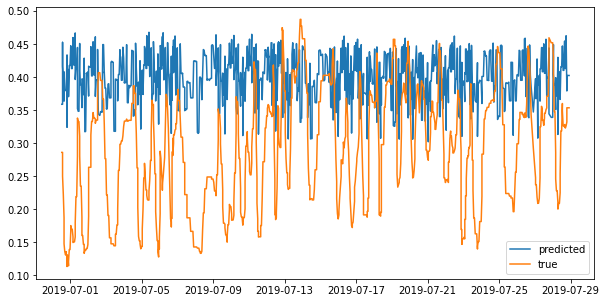

In [170]:
plt.figure(figsize=(10,5))
plt.plot(df_prdct_tr.predict[0:1000], label='predicted')
plt.plot(df_prdct_tr.true[0:1000], label='true')
plt.legend()
#plt.yscale('log')

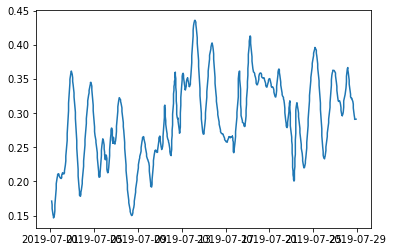

In [163]:
plt.plot(df_prdct_tr.true.rolling(24).mean())

In [155]:
10000/24

416.6666666666667

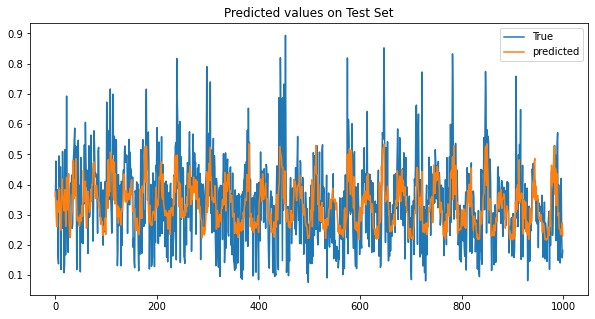

In [176]:
import matplotlib.pyplot as plt
ind1=3000
ind2=3500
pl.figure(figsize=(10,5))
pl.plot(y_trainn[0:1000,0,0], label="True")
pl.plot(model.predict(x_trainn[0:1000,:,:]), label="predicted")
#pl.plot(y_testn[1,:,0], label="true")
pl.title("Predicted values on Test Set")
pl.legend(loc="upper right")

In [82]:
model.predict(x_testn[0:1,:,:])

array([[0.27160436]], dtype=float32)

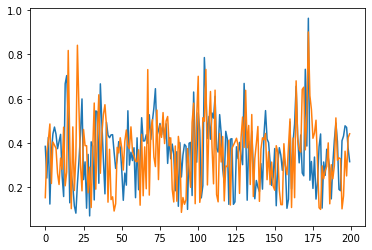

In [39]:
pl.plot(y_trainn[0:200,5,0], label="1")
pl.plot(y_trainn[0:200,15,0], label="2")

In [0]:
x_prdct= model.predict(x_trainn)

In [33]:
shape(x_prdct), shape(y_trainn)

((1000, 1), (1000, 170, 1))

In [0]:
x_testn[0,:,:], y_testn.shape

In [0]:
shape(model.predict(x_testn[0:1]))

(1, 1)

In [40]:
nanmin(history.history["val_loss"])

0.01973831094801426